In [41]:
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
data_path = 'data/ch8/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

Files already downloaded and verified
Files already downloaded and verified


# 8.1

지역화된 패턴이 어떤 위치에 있더라도 동일하게 출력에 영향을 주는 성질을 __평행이동 불변성__이라 한다.

컨볼루션은 이미지에 대한 지역벅인, 평행이동 불변성을 보장하는 선형연산이 존재한다. 

이미지를 가중치행렬인 커널을 이용해 컨볼루션 연산을 수행한다. 이를 통해 더 적은 파라미터 사용이 가능하다.

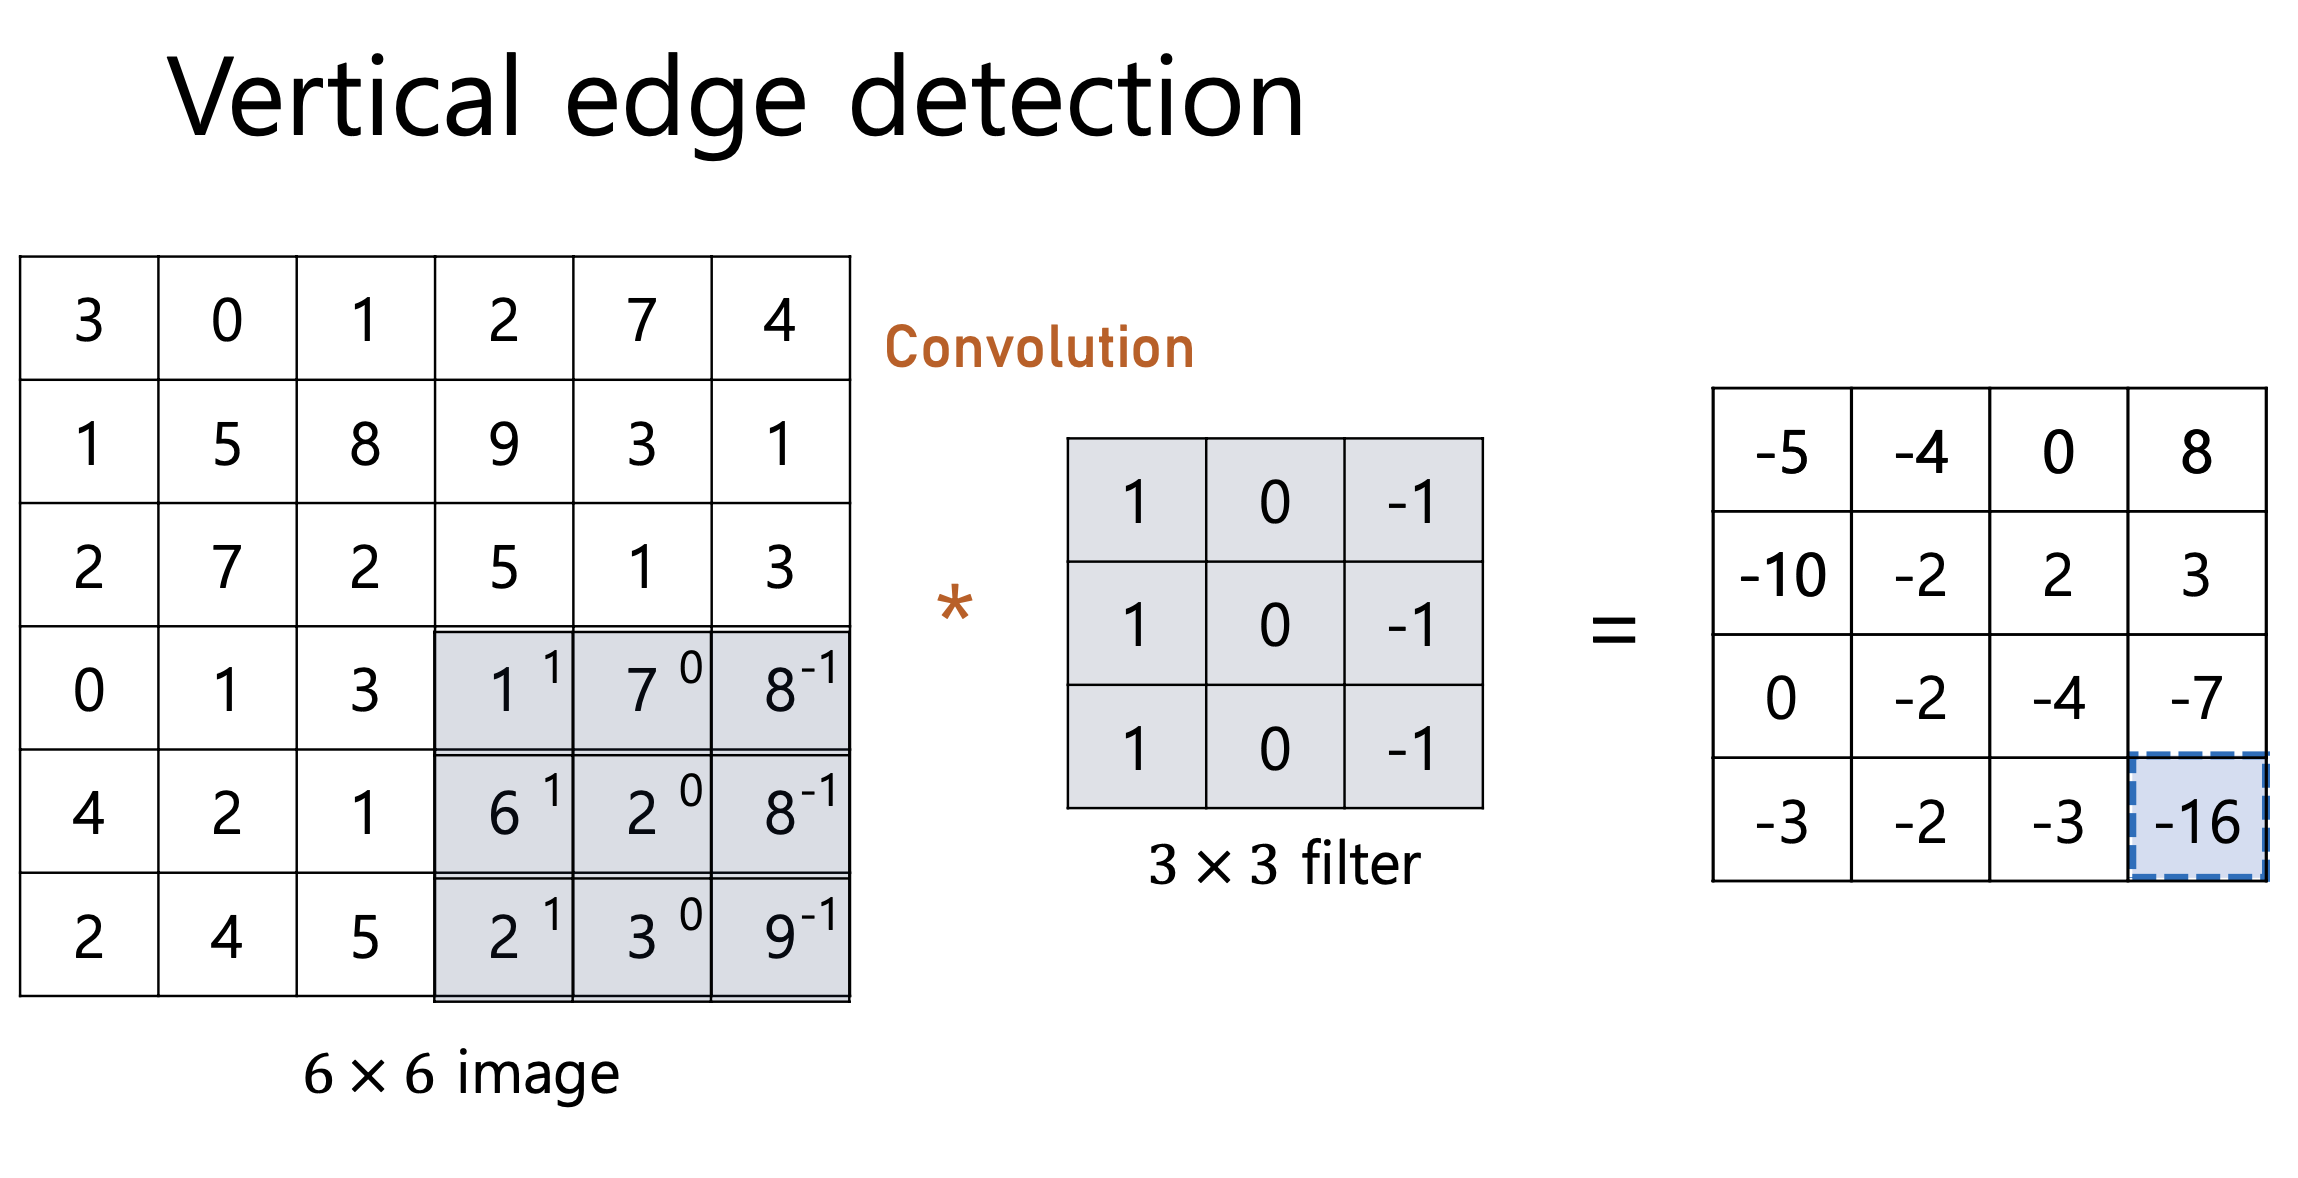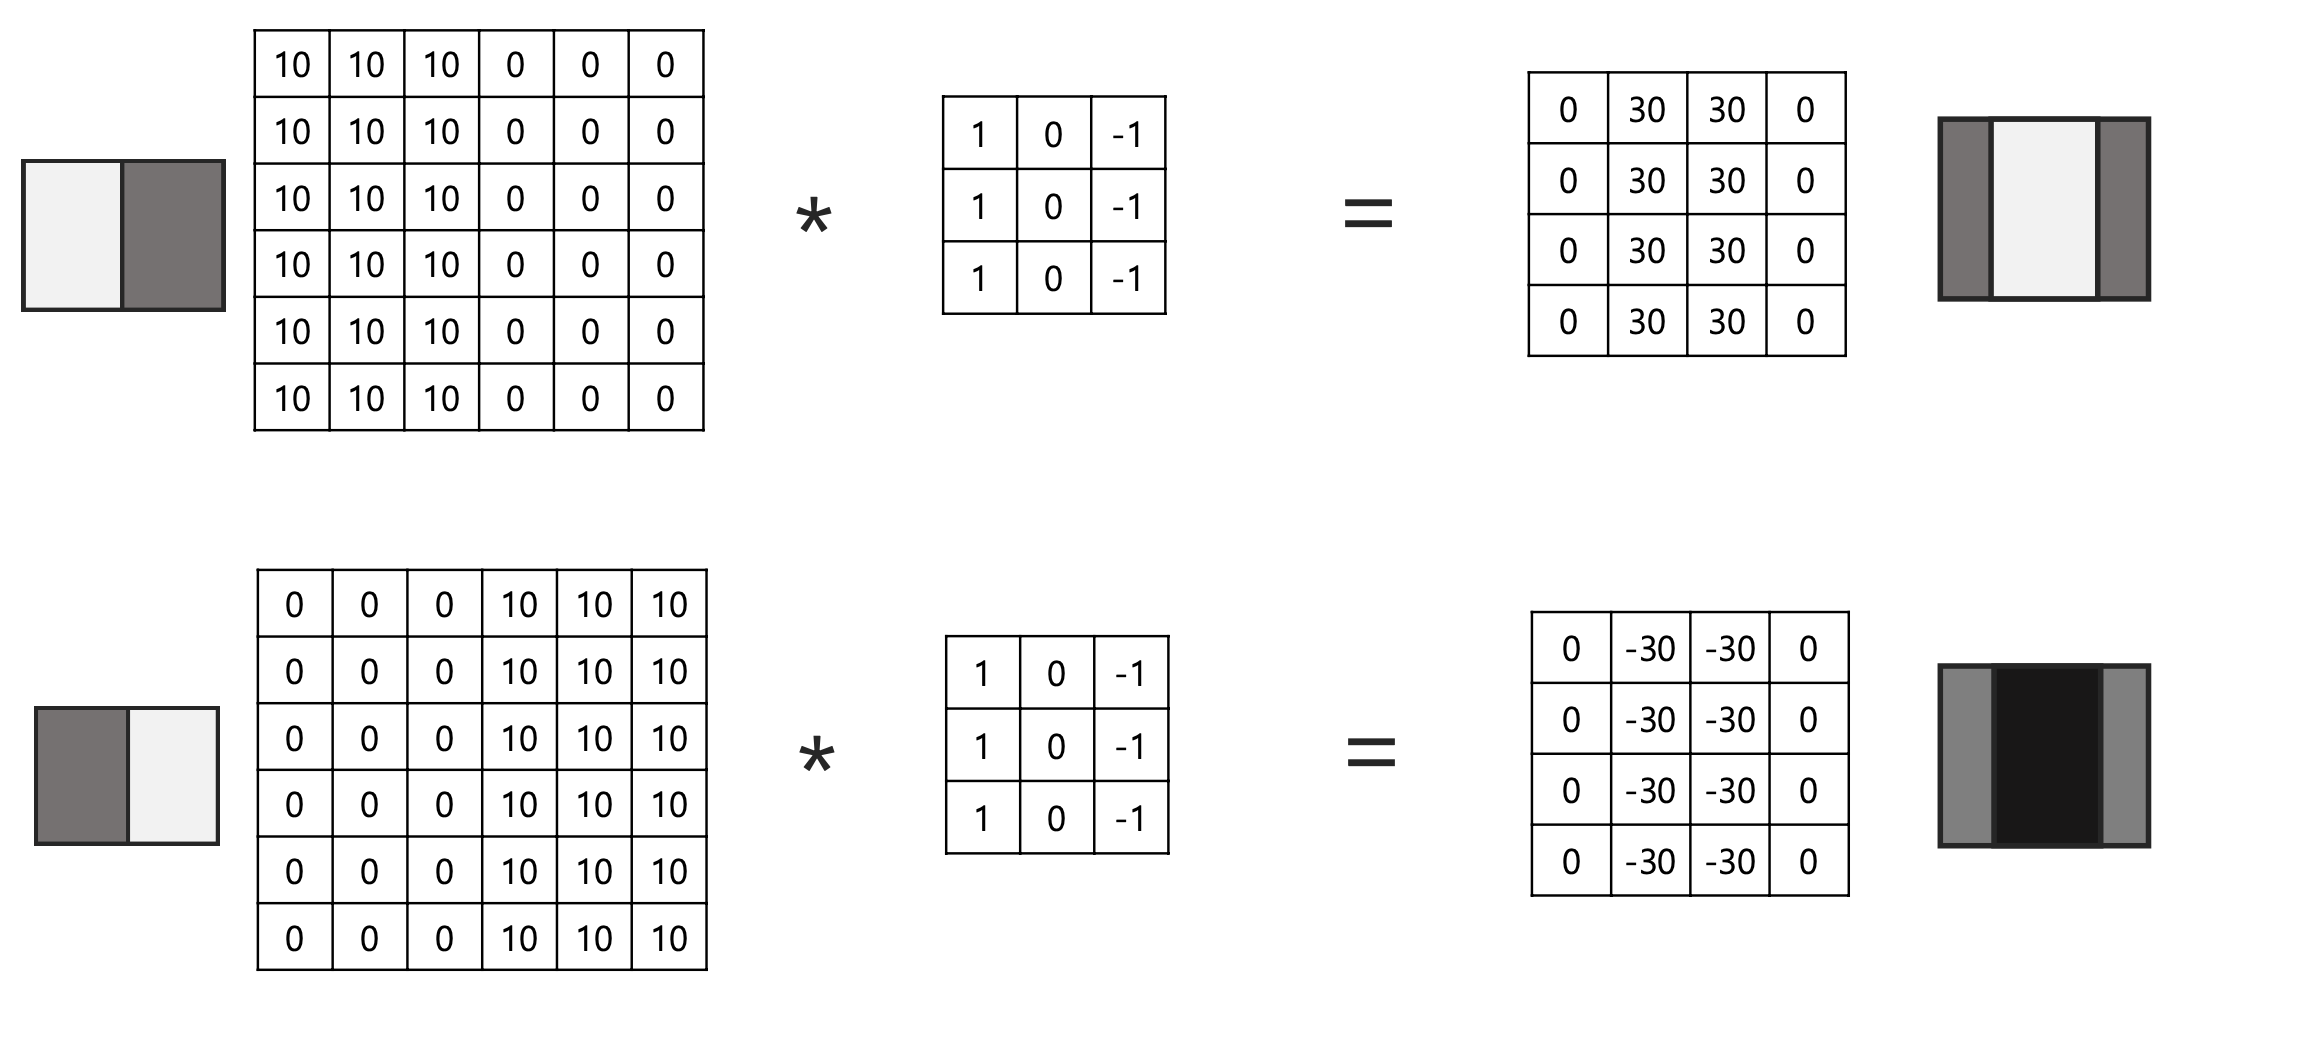

# 8.2

- nn.Conv1d: 시계열용
- nn.Conv2d: 이미지용
- nn.Conv3d: 용적데이터나 동영상용

커널의 크기는 일반적으로 모든 방향으로 동일하게 만든다 따라서 kernel_size=3으로 하면 1차원은 3, 2차원은 3x3, 3차원은 3x3x3으로 인식한다.


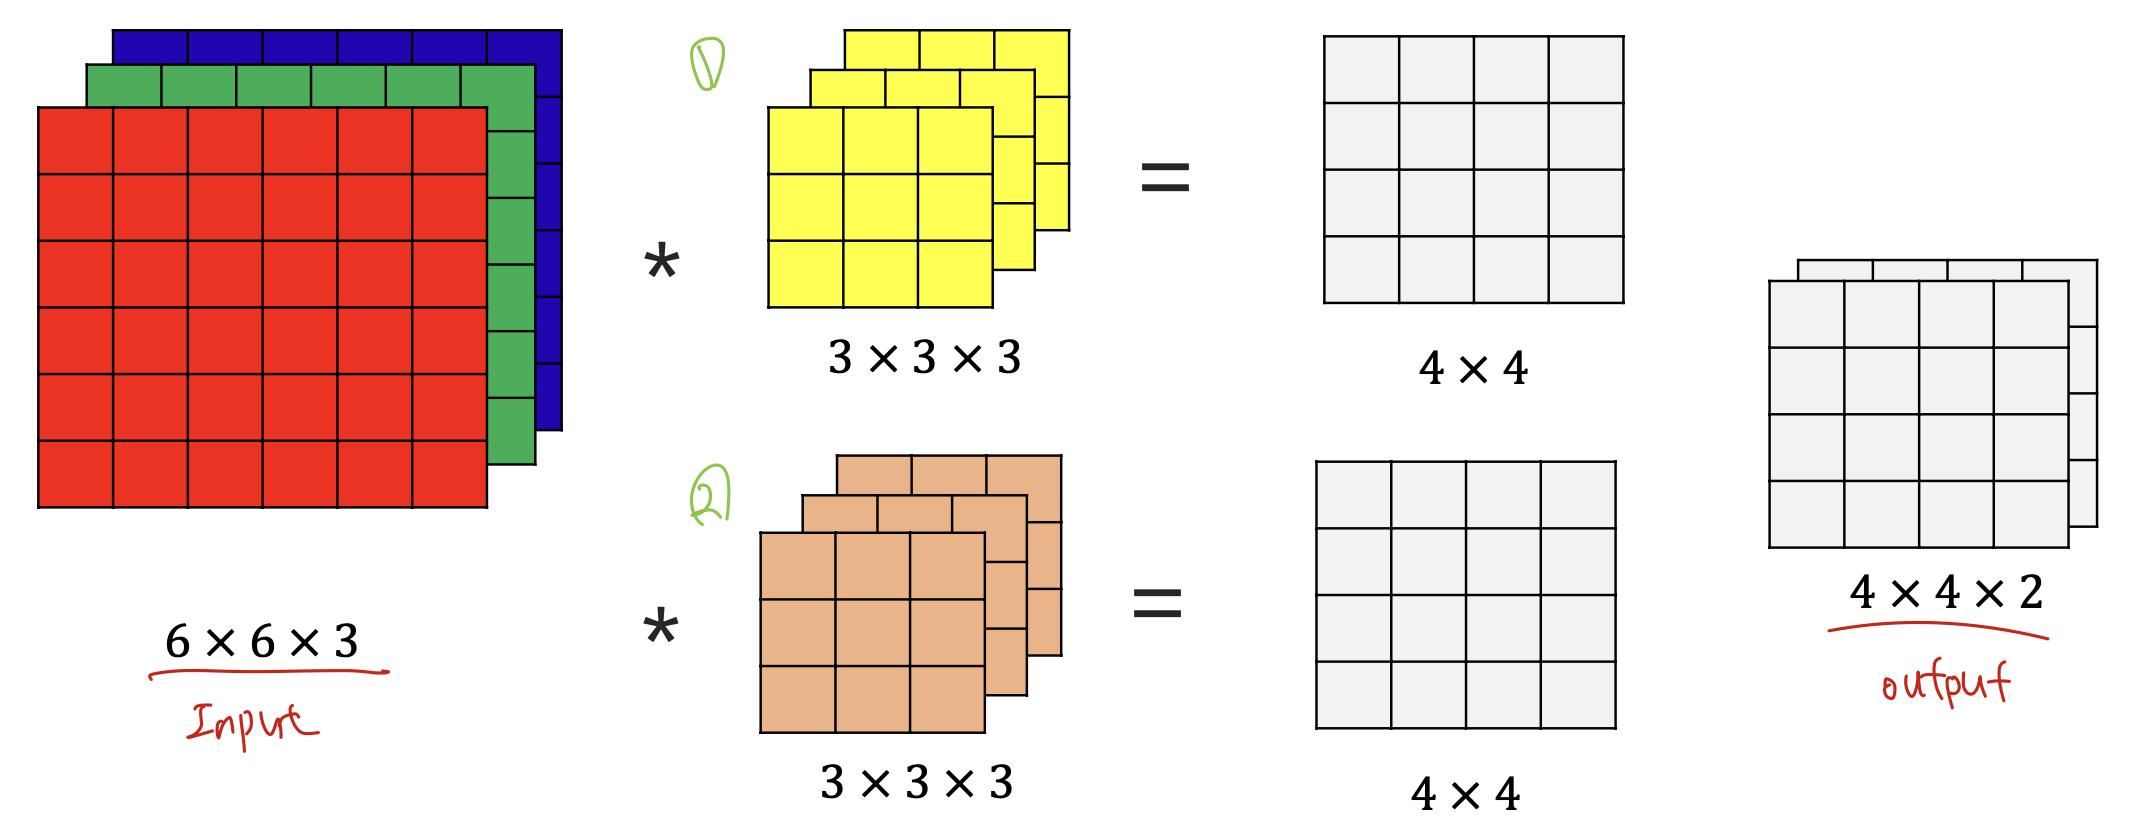

In [42]:
conv = nn.Conv2d(3, 16, kernel_size=3) #3은 채널수,출력 피처는 임의로 16을 지정
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [43]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [44]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0)) #img.unsqueeze.shape: [1,3,32,32]
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

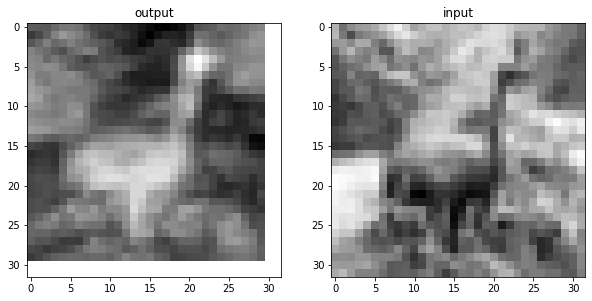

In [45]:
plt.figure(figsize=(10, 4.8))
ax1 = plt.subplot(1, 2, 1)
plt.title('output')
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1) 
plt.imshow(img.mean(0), cmap='gray') 
plt.title('input') 
plt.show()

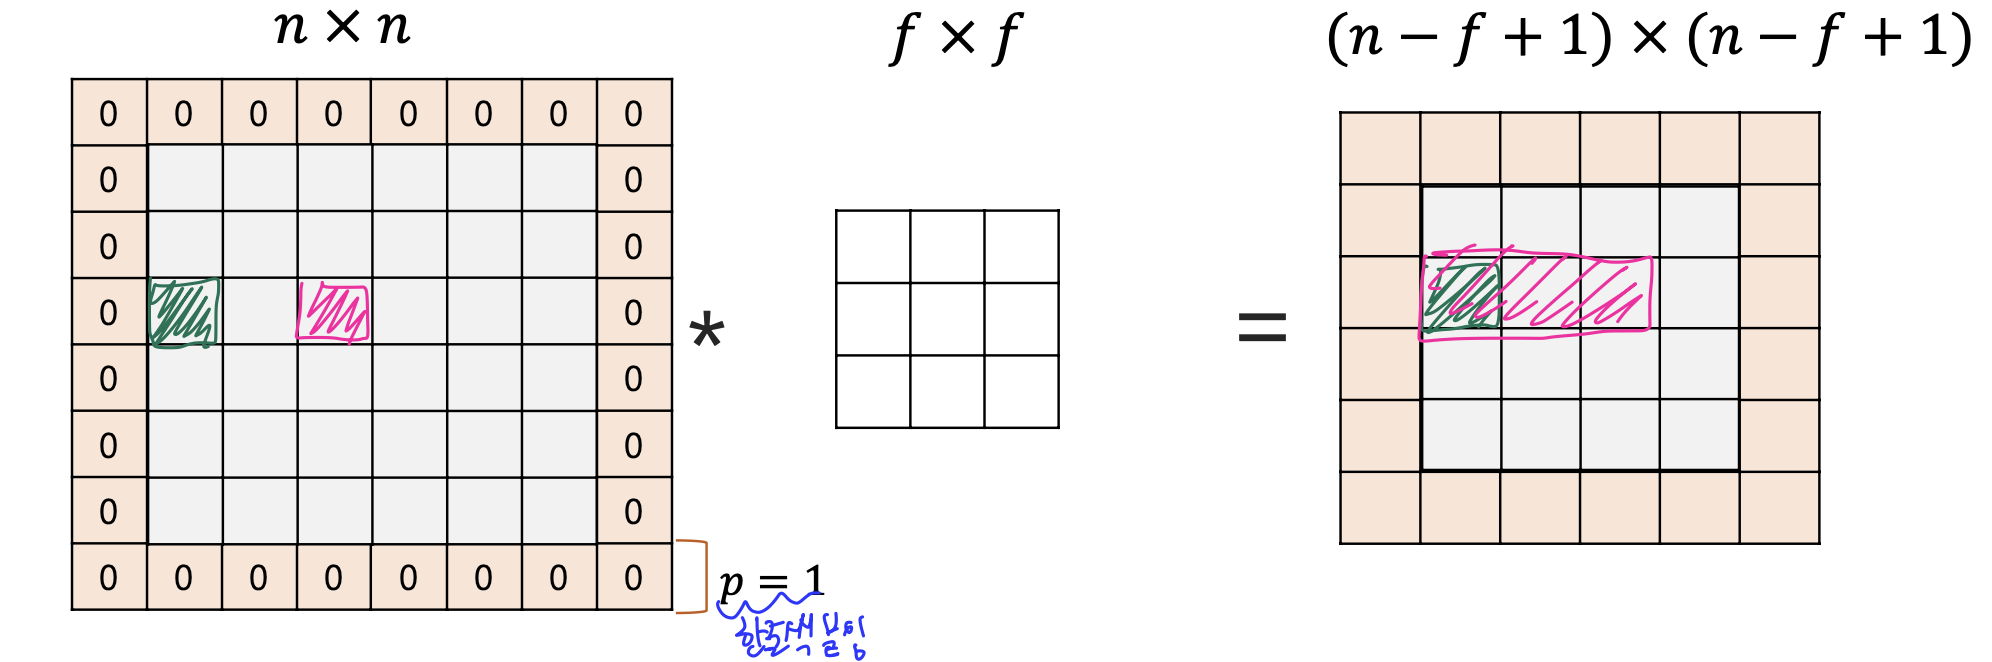

- 컨볼루션 구조 자체에 신경을 더 쓸 수 있음
- 컨볼루션과 이미지 크기 변경문제를 별도로 분리해 기억해야 하는 사항을 줄일 수 있다.
- 이미지 경계에서 이뤄지는 작업에 따른 부작용 없애줌

In [46]:
#패딩: 이미지 경계에서 이뤄지는 작업에 따른 부작용을 없애주기 위해 패딩을 사용한다. 이미지 경계에 값이 0인 가짜 픽셀을 패딩해줘 이미지 경계에 대한 값들이 모드 잘 들어가게 해준다.
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1) # <1>
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [47]:
#bias를 0으로 제거해 교란변수를 배제
with torch.no_grad():
    conv.bias.zero_()

#weight를 상수값으로 넣어 출력에서의 각 픽셀이 자신의 이웃 픽셀에 대한 평균을 가지게 함
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

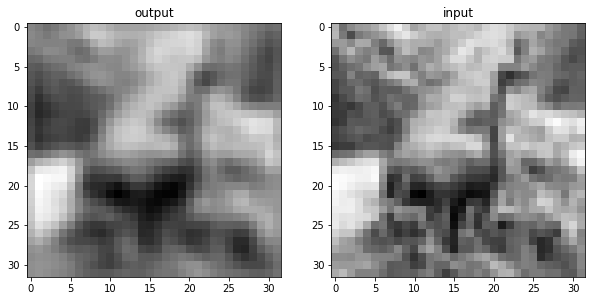

In [48]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8)) 
ax1 = plt.subplot(1, 2, 1)  
plt.title('output') 
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  
plt.imshow(img.mean(0), cmap='gray')  
plt.title('input') 
plt.show()

In [49]:
#다른커널로 바꿔서 출력
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

#다른 두 인접한 영역사이에서 수직경계 커널이 적용되면 높은 값을 가지게 되어 이 커널은 가로로 인접한 두 영역 사이의 수직경계를 탐색하는 역활임

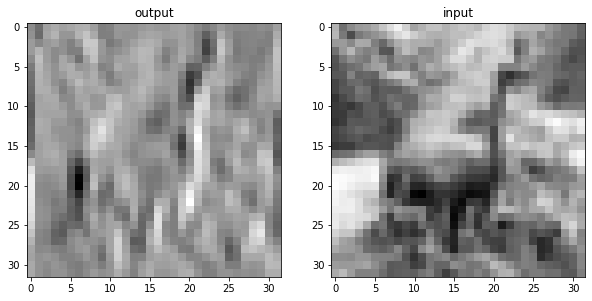

In [50]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8)) 
ax1 = plt.subplot(1, 2, 1)  
plt.title('output')  
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1) 
plt.imshow(img.mean(0), cmap='gray') 
plt.title('input') 
plt.show()

다운샘플링 : 큰 신경
- 맥스풀링: 커널 사이즈만큼 적용해서 최댓값 사용
- 평균풀링: 커널 사이즈만큼 적용해서 평균값 사용
- 스트라이드 적용: 컨볼루션 연산시 한칸씩이 아닌 스트라이드 값만큼 건너뛰면서 연산

In [51]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [52]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # 선형결합에 들어가려면 flatten을 해줘야함.
            nn.Linear(8 * 8 * 8, 32), #MaxPool2d의 출력크기 의존하여 입력값정해짐 
            nn.Tanh(),
            nn.Linear(32, 2)) #컨볼루션->활성화함수->다운샘플링 순서.


numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [53]:
#model(img.unsqueeze(0)) 

#이렇게 사용하면 차원이 맞지 않아 오류발생함. 따라서 view를 호출해 차원을 바꿔줘야하는데 이때 forward사용한다.

#하지만 nn.Sequential은 forward가 아닌 call함수를 사용하기 때문에 각 모돌의 출력을 명시적으로 볼 수 없다.

# 8.3

기존에 만들어진 모듈에서 지원하지 않는 연산이 필요할때가 있어서 직접 만들 수 있어야 한다. nn.Module을 이용한다. nn.Sequential은 기존에만들어진 것만을 지원한다.

##### nn.Module로 정의된 신경망

- \_\_init\_\_(): 생성자로 레이어들을 구성함. 여기서 정의하고 self에 할당해서 forward함수에서 사용함.
- forward(): 호출해서 사용하는 부분.

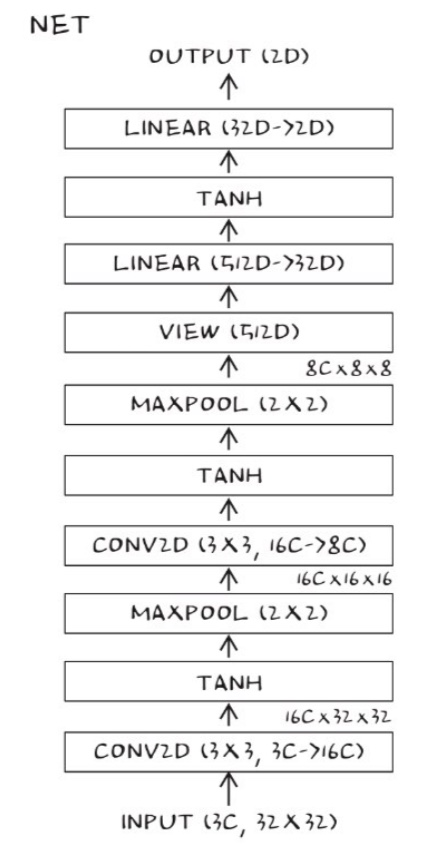 


In [54]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) # flatten해준뒤 선형결합으로 들어감
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [55]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

분류신경망의 목적은 큰 수의 픽셀을 가진 이미지에서 출발해 정보를 압축해가면서 분류클래스의 확률벡터로 만드는 것인데 중간에 나타나는 값들이 점점 줄어드는 것을 볼 수 있다.

나중에 볼 레즈넷등 큰 신경망들에 예외가 있긴함

\


nn모듈을 사용하면 서브클래스의 메소드라면 언제든 호출이 가능하다. 훈련과정이 실제사용때와 많이 다르면 predict함수를 따로 만드는 등 다양하게 변형이 가능하다.

model.parameters()에서 함수호출은 생성자에서 속성으로 할단된 모든 서브모듈들을 찾아 이들의 parameters()를 재귀적으로 호출한다.

따라서 생성자에서 서브모듈을 등록하는 과정에서 파라미터가 없는 풀링이나 활성화 함수들은 따로 등록하지 않고 forward에서 호출시키는게 더 쉽다.

forward에서 생성자에서 등록시키지 않은 활성화 함수를 사용하기 위해 torch.nn.functional를 임포트시켜 함수를 제공받는다.

In [56]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [57]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.1745, -0.0974]], grad_fn=<AddmmBackward0>)

# 8.4

In [58]:
# 훈련과정의 반복문은 중첩된 두 루프를 가짐 - 바깥: 에포크단위, 안: Dataset에서 배치를 만드는 DataLoader단위
import datetime  

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):  # 에포크
        loss_train = 0.0
        for imgs, labels in train_loader:  
            
            outputs = model(imgs)  
            loss = loss_fn(outputs, labels)  
            optimizer.zero_grad()  # 이전기울기값 0으로 지움
            loss.backward()  #역전파 수행하면서 파라미터에 대한 기울기 계산
            optimizer.step()  #파라미터 업데이트

            loss_train += loss.item()  #에포크마다 확인한 손실값을 모두 더함

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))  # 평균손실값을 구한다.

In [59]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)  #배치사이즈로 묶어줌

model = Net()  
optimizer = optim.SGD(model.parameters(), lr=1e-2)  
loss_fn = nn.CrossEntropyLoss() 

training_loop(  
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2022-09-13 04:30:56.134085 Epoch 1, Training loss 0.5807432864501978
2022-09-13 04:31:30.374238 Epoch 10, Training loss 0.32364296571464296
2022-09-13 04:32:05.720581 Epoch 20, Training loss 0.2884434933780105
2022-09-13 04:32:43.057912 Epoch 30, Training loss 0.26537433622559164
2022-09-13 04:33:23.503453 Epoch 40, Training loss 0.247692254413465
2022-09-13 04:33:59.289568 Epoch 50, Training loss 0.23155739893958827
2022-09-13 04:34:35.070459 Epoch 60, Training loss 0.2168403471446341
2022-09-13 04:35:11.513614 Epoch 70, Training loss 0.20225090557222913
2022-09-13 04:35:52.478203 Epoch 80, Training loss 0.1908932228329455
2022-09-13 04:36:33.718740 Epoch 90, Training loss 0.17596680979440166
2022-09-13 04:37:09.424190 Epoch 100, Training loss 0.16078600683694433


In [60]:
#검증셋을 활용한 정확도 측정
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  # 파라미터 업데이트 안하니까 기울기 필요없음
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # 확률값 제일 높은 값을 가지는 인덱스 출력
                total += labels.shape[0]  # 배치 크기만큼 증가시킴
                correct += int((predicted == labels).sum())  # 맞은 경우에만 값을 더해줌

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.89
Accuracy val: 0.87


In [61]:
#모델 저장
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

#모델 불러오기
loaded_model = Net() 
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

In [62]:
#GPU에서 훈련 가능
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

#Module.to는 모듈 인스턴스 자체수정, Tensor.to는 새로운 텐서를 반환.
#따라서 원하는 디바이스로 파라미터를 이동시킨후에 Optimizer를 만들어 구현하는 방식으로 하자.
#GPU로 옮기면 Tensor.to메소드로 데이터로더가 올려준 텐서를 GPU로 옮기도록 훈련루프를 수정하면 된다.

Training on device cuda.


In [63]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)  #gpu로
            labels = labels.to(device=device) #gpu로
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))
#validate함수에서도 동일하게 수정하면 됨.


train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)
all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict


In [64]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = Net().to(device=device)  # 모델도 인스턴스화 하고 device로 옮긴다.
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_acc_dict["baseline"] = validate(model, train_loader, val_loader)

2022-09-13 04:37:12.870520 Epoch 1, Training loss 0.5633787068591756
2022-09-13 04:37:16.219744 Epoch 10, Training loss 0.3302317670765956
2022-09-13 04:37:19.906952 Epoch 20, Training loss 0.29676574905207204
2022-09-13 04:37:23.852589 Epoch 30, Training loss 0.2666749037375116
2022-09-13 04:37:27.728943 Epoch 40, Training loss 0.24383027452951783
2022-09-13 04:37:31.359816 Epoch 50, Training loss 0.2260219077016138
2022-09-13 04:37:34.999599 Epoch 60, Training loss 0.20936384313045794
2022-09-13 04:37:38.653392 Epoch 70, Training loss 0.19299106328350724
2022-09-13 04:37:42.298611 Epoch 80, Training loss 0.18001309881924063
2022-09-13 04:37:45.902900 Epoch 90, Training loss 0.16436366442662137
2022-09-13 04:37:49.854871 Epoch 100, Training loss 0.15162961623945814
Accuracy train: 0.94
Accuracy val: 0.89


모델의 파라미터를 저장할때 디바이스를 기억했다가 그 디바이스에서 불러와야한다. 따라서 디바이스 정보까지 같이 저장하는 방법을 사용한다.

In [65]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt',
                                        map_location=device))

<All keys matched successfully>

# 8.5


In [66]:
# 신경망의 너비 차원을 넓히기, 컨볼루션의 채널 수에 해당하는 값임
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

model=NetWidth()
sum(p.numel() for p in model.parameters()) #모델의 총 파라미터수

  #모델의 용량 증가됨, 용량이 커질 수록 입력이 다양해지고 과적합될 가능성도 커진다.

38386

### 과적합을 피하기위해 일반화 하기: 정규화
##### 파라미터 제어하기: 가중치 패널티

손실값에 정규화 항을 넣는방법. 이 정규화 항을 조작해서 가중치가 상대적으로 작게 만든다. 훈련을 통해 증가할 수 있는 크기를 제한하는것이다. 큰 가중치값에 페널티를 부과해 손실값은 다소 매끄러워지며 개별 샘플에 맞춰서 얻는 이득이 상대적으로 줄어들게 된다.

- L1 Norm : 모델의 모든 가중치 절댓값의 합
- L2 Norm : 모델의 모든 가중치에 대한 제곱합

https://wooono.tistory.com/221

In [67]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn,
                        train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0 #에포크마다 더해질 예정이니까 0으로 초기화
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001 #하이퍼파라미터로 직접 지정
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters())  #L1정규화 하면 pow(2.0)을 abs()로 바꿈
            loss = loss + l2_lambda * l2_norm #기존 손실함수에 정규화항인 l2_norm을 넣어 정규화진행

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))
            
#근데 파이토치의 SGD옵티마이저에는 이미 weight_decay파라미터가 있어서 직접 이렇게 코딩할 필요 없음
#optimizier = torch.optim.SGD(model.parameters(),lr=1e-3,weight_decay=0.9) 이런식으로 optimizer정의할때 파라미터에 넣어주면 됨.

In [68]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_l2reg(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["l2 reg"] = validate(model, train_loader, val_loader)

2022-09-13 04:37:50.672455 Epoch 1, Training loss 0.5833198401578672
2022-09-13 04:37:55.193058 Epoch 10, Training loss 0.3455202645936589
2022-09-13 04:38:01.465281 Epoch 20, Training loss 0.3165062346086381
2022-09-13 04:38:07.985957 Epoch 30, Training loss 0.29548328146813024
2022-09-13 04:38:13.943310 Epoch 40, Training loss 0.2810851275256485
2022-09-13 04:38:19.810281 Epoch 50, Training loss 0.26644988842071243
2022-09-13 04:38:25.612765 Epoch 60, Training loss 0.2514127308775665
2022-09-13 04:38:31.748789 Epoch 70, Training loss 0.24026829697144259
2022-09-13 04:38:39.448296 Epoch 80, Training loss 0.2303165378654079
2022-09-13 04:38:44.478696 Epoch 90, Training loss 0.22512995589310955
2022-09-13 04:38:49.818344 Epoch 100, Training loss 0.21423337613321414
Accuracy train: 0.93
Accuracy val: 0.89


##### 드랍아웃

신경망의 뉴런 출력을 랜덤하게 0으로 만들기. 이방법을 활용하면 훈련마다 다른 뉴런들이 만들어져 과적합을 방지한다.

위치
- 여러계층의 컨볼루션 사이
- 비선형 활성함수와 선형함수 사이

In [69]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [70]:
model = NetDropout(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["dropout"] = validate(model, train_loader, val_loader)

2022-09-13 04:38:50.963874 Epoch 1, Training loss 0.5817845355553232
2022-09-13 04:38:55.796603 Epoch 10, Training loss 0.3851262080441615
2022-09-13 04:39:01.246444 Epoch 20, Training loss 0.3512939414021316
2022-09-13 04:39:06.309956 Epoch 30, Training loss 0.3327011255321989
2022-09-13 04:39:11.487392 Epoch 40, Training loss 0.3143404473544686
2022-09-13 04:39:16.086743 Epoch 50, Training loss 0.29540288571719153
2022-09-13 04:39:21.286900 Epoch 60, Training loss 0.28522081445356845
2022-09-13 04:39:26.463578 Epoch 70, Training loss 0.27073214369215026
2022-09-13 04:39:31.341010 Epoch 80, Training loss 0.2602840025144018
2022-09-13 04:39:36.291761 Epoch 90, Training loss 0.2512883932632246
2022-09-13 04:39:40.893036 Epoch 100, Training loss 0.23911355919898694
Accuracy train: 0.90
Accuracy val: 0.88


##### 활성함수 억제하기: 배치정규화

학습률을 높이면서, 훈련은 초기화에 영향을 덜 받고 정규화처럼 동작해 드랍아웃에 대한 대체 방법을 설명한다.
입력볌위를 활성함수로 바꿔서 미니배치가 원하는 분포를 가지게 한다. 활성화 함수에 들어가기 전에 미니배치별로 정규화를 진행한다.
배치 정규화의 목적은 활성함수의 입력범위를 조정하는것이므로 선형변환 뒤에 위치한다.

In [72]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, 
                               padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

#미니배치가 실행되면 현재의 미니배치에 대한 평균고 표준편차를 구하는것과 더불어 파이토치가 전체 데이터셋에 대한 평균과 표준편차도 대략적으로 업데이트 하기때문에 model.eval()을 명시해야 한다.
#모델이 배치 정규화 모듈을 가지는 경우 추정값을 고정하고 정규화에 사용하기만 한다.
#동작중인 추정을 해제하고 다시 미니배치 통계를 추정하기 원한다면 model.train()호출한다.

In [73]:
model = NetBatchNorm(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["batch_norm"] = validate(model, train_loader, val_loader)

2022-09-13 04:41:14.868268 Epoch 1, Training loss 0.4763926875059772
2022-09-13 04:41:20.180323 Epoch 10, Training loss 0.26661778317325435
2022-09-13 04:41:27.240721 Epoch 20, Training loss 0.21378955093159038
2022-09-13 04:41:32.000513 Epoch 30, Training loss 0.17340502826271542
2022-09-13 04:41:36.796708 Epoch 40, Training loss 0.13683789228178134
2022-09-13 04:41:41.569672 Epoch 50, Training loss 0.10901400655697865
2022-09-13 04:41:46.866083 Epoch 60, Training loss 0.08146013853371523
2022-09-13 04:41:53.496420 Epoch 70, Training loss 0.062413985704540445
2022-09-13 04:41:58.738326 Epoch 80, Training loss 0.04449176091914344
2022-09-13 04:42:04.417702 Epoch 90, Training loss 0.032277020412218416
2022-09-13 04:42:09.186197 Epoch 100, Training loss 0.02490586467134725
Accuracy train: 0.96
Accuracy val: 0.86


### 깊은 신경망에 대해 배우기

##### 스킵커넥션

residual network인 ResNet을 만들었다. 이를 통해 계층을 깊게 쌓은 딥러닝 신경망이 가능해졌다. 스킵커넥션은 입력을 계층블럭의 출력에 연결하는것으로서 파라미터에 대한 손실함수가 크게 바뀌어도 자기 원본에 대한 정보를 함께 가지고 있기 때문에 작은 값들이 사라져 버리거나 큰값이 만들어져도 영향을 많이 받지 않는다.

In [74]:
#스킵커넥션을 사용하지 않은 모델

class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out


#스킵커넥션을 사용한 모델
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out ###스킵커넥션
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2) ###스킵커넥션
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [75]:
model = NetDepth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["depth"] = validate(model, train_loader, val_loader)

2022-09-13 05:01:03.091747 Epoch 1, Training loss 0.6850584855504857
2022-09-13 05:01:08.057073 Epoch 10, Training loss 0.3531062854513241
2022-09-13 05:01:12.979972 Epoch 20, Training loss 0.30799326424006446
2022-09-13 05:01:18.885721 Epoch 30, Training loss 0.27930968838512515
2022-09-13 05:01:23.724843 Epoch 40, Training loss 0.24867437068064502
2022-09-13 05:01:28.184570 Epoch 50, Training loss 0.22563727693572924
2022-09-13 05:01:32.649491 Epoch 60, Training loss 0.19555286835333344
2022-09-13 05:01:37.074087 Epoch 70, Training loss 0.17677100434614595
2022-09-13 05:01:41.490653 Epoch 80, Training loss 0.15475454959709933
2022-09-13 05:01:45.908900 Epoch 90, Training loss 0.13125027542945686
2022-09-13 05:01:50.377064 Epoch 100, Training loss 0.10641175935602491
Accuracy train: 0.97
Accuracy val: 0.90


In [76]:
model = NetRes(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res"] = validate(model, train_loader, val_loader)

2022-09-13 05:01:51.111204 Epoch 1, Training loss 0.6222009636034631
2022-09-13 05:01:55.250912 Epoch 10, Training loss 0.3302607095924912
2022-09-13 05:01:59.702855 Epoch 20, Training loss 0.2817738692092288
2022-09-13 05:02:04.159412 Epoch 30, Training loss 0.24983458448747162
2022-09-13 05:02:08.591186 Epoch 40, Training loss 0.21501810967352739
2022-09-13 05:02:13.041856 Epoch 50, Training loss 0.18525560143267272
2022-09-13 05:02:17.504129 Epoch 60, Training loss 0.15915193584314577
2022-09-13 05:02:22.095463 Epoch 70, Training loss 0.14538023525932034
2022-09-13 05:02:26.896779 Epoch 80, Training loss 0.11275546326284196
2022-09-13 05:02:31.395387 Epoch 90, Training loss 0.08708830364048481
2022-09-13 05:02:35.866677 Epoch 100, Training loss 0.06744545351737624
Accuracy train: 0.97
Accuracy val: 0.90


##### 깊은 모델 만들기

- ResBlock

- NetResDeep

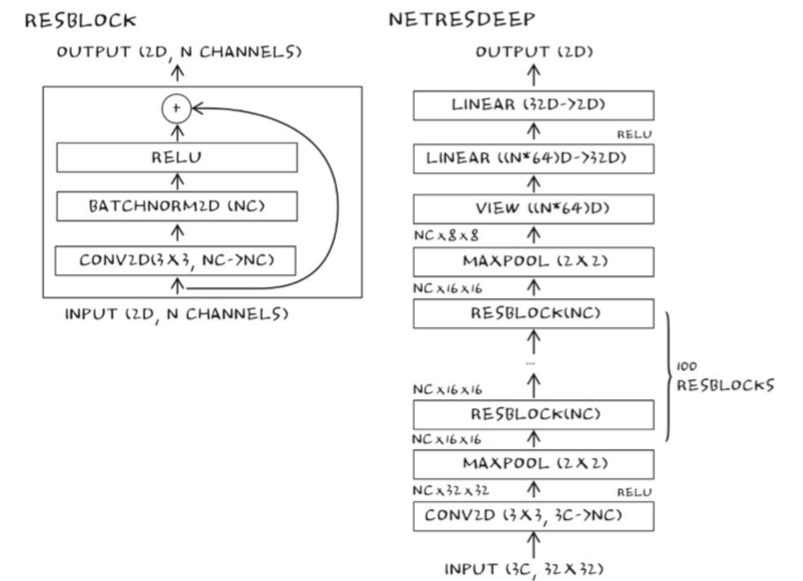

In [86]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                              padding=1, bias=False)  # BatchNorm계층은 편향값의 효과를 상쇄하므로 bias는 생략함.
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity='relu')  # .kaiming_normal_은 표준편차를 가지는 표준 랜덤요소로 초기화해줌(커스텀 초기화), 배치정규화는 기본값으로 평균0과 분산 0.5를 가지는 분포의 출력을 만들도록 초기화.
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [79]:
model = NetResDeep(n_chans1=32, n_blocks=100).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res deep"] = validate(model, train_loader, val_loader)

2022-09-13 05:21:08.368943 Epoch 1, Training loss 4.918683098379973
2022-09-13 05:22:32.704303 Epoch 10, Training loss 0.4408204034445392
2022-09-13 05:24:10.466040 Epoch 20, Training loss 0.33108303140682777
2022-09-13 05:25:48.416206 Epoch 30, Training loss 0.2870001232927772
2022-09-13 05:27:22.739857 Epoch 40, Training loss 0.24956672785768083
2022-09-13 05:28:57.765067 Epoch 50, Training loss 0.22425377022498733
2022-09-13 05:30:29.109508 Epoch 60, Training loss 0.19234116209350574
2022-09-13 05:32:00.048062 Epoch 70, Training loss 0.1675679726632917
2022-09-13 05:33:31.228502 Epoch 80, Training loss 0.14945111891171733
2022-09-13 05:35:02.094595 Epoch 90, Training loss 0.12301369864422425
2022-09-13 05:36:33.132195 Epoch 100, Training loss 0.10444439558466528
Accuracy train: 0.93
Accuracy val: 0.85


##### 초기화
처음 파라미터 초기화할때 초기값이 성능에 영향을 준다. 이와 관련된 다양한 기법들이 존재한다.


### 모델의 성능비교

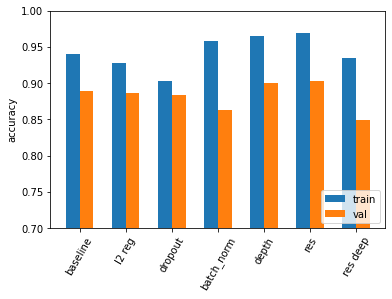

In [80]:
trn_acc = [v['train'] for k, v in all_acc_dict.items()]
val_acc = [v['val'] for k, v in all_acc_dict.items()]

width =0.3
plt.bar(np.arange(len(trn_acc)), trn_acc, width=width, label='train')
plt.bar(np.arange(len(val_acc))+ width, val_acc, width=width, label='val')
plt.xticks(np.arange(len(val_acc))+ width/2, list(all_acc_dict.keys()),
           rotation=60)
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim(0.7, 1)
plt.show()

# 8.7 연습문제

## 1

In [84]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)
for imgs, labels in train_loader:
  imgs = imgs.to(device=device)
imgs[0].shape

torch.Size([3, 32, 32])

In [89]:
train_loader = torch.utils.data.DataLoader(cifar2, shuffle=True)
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=5, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 6 * 6) 
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out


def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)  #gpu로
            labels = labels.to(device=device) #gpu로
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))


def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict


model = Net().to(device=device)  # 모델도 인스턴스화 하고 device로 옮긴다.
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

validate(model, train_loader, val_loader)

2022-09-13 06:05:31.998259 Epoch 1, Training loss 0.4267812235141173
2022-09-13 06:08:06.105181 Epoch 10, Training loss 0.26061756756832766
2022-09-13 06:10:53.586084 Epoch 20, Training loss 0.19618737994307894
2022-09-13 06:13:41.988740 Epoch 30, Training loss 0.16952457586298342
2022-09-13 06:16:30.285586 Epoch 40, Training loss 0.16911167090233103
2022-09-13 06:19:18.401456 Epoch 50, Training loss 0.1494164568750379
2022-09-13 06:22:06.080192 Epoch 60, Training loss 0.14989860062289548
2022-09-13 06:24:53.829750 Epoch 70, Training loss 0.14791302105387596
2022-09-13 06:27:41.399119 Epoch 80, Training loss 0.14147300830516332
2022-09-13 06:30:28.620480 Epoch 90, Training loss 0.15104383422102474
2022-09-13 06:33:15.101884 Epoch 100, Training loss 0.12837084291053558
Accuracy train: 0.96
Accuracy val: 0.86


{'train': 0.9598, 'val': 0.856}